코드 3-1

In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install ftfy regex tqdm
!pip install torch torchvision

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1vzmjk__
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1vzmjk__
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=7f06fa2759c2130ce71d98a3823f7c6d2a2c16692830f5c9e35d4adb4d06cd69
  Stored in directory: /tmp/pip-ephem-wheel-cache-tu8vfuwk/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [3]:
import clip
import torch
from PIL import Image

# 1. 모델 로딩
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 2. 입력 텍스트 및 이미지
texts = ["a photo of a dog", "a photo of a cat"]
image = preprocess(Image.open("dog.png")).unsqueeze(0).to(device)

# 3. 인코딩 수행
text_tokens = clip.tokenize(texts).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_tokens)

# 4. 유사도 계산
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T)
probs = similarity.softmax(dim=-1)

print("Matching Probabilities:", probs)


Matching Probabilities: tensor([[0.9949, 0.0051]])


In [4]:
import clip
import torch
from PIL import Image
import torch.nn.functional as F

# 1. 모델 로딩 및 입력 준비
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("cat.png")).unsqueeze(0).to(device)
texts = clip.tokenize(["a photo of a cat", "a photo of a dog"]).to(device)

# 2. 임베딩 추출
with torch.no_grad():
    img_feat = model.encode_image(image)
    txt_feat = model.encode_text(texts)

# 3. 정규화 후 유사도 계산
img_feat = F.normalize(img_feat, dim=-1)
txt_feat = F.normalize(txt_feat, dim=-1)

# Cosine Similarity (정규화 후 Dot Product와 동일)
cos_sim = img_feat @ txt_feat.T  # shape: (1, 2)

# Euclidean Distance
eucl_dist = torch.norm(img_feat - txt_feat, dim=-1)

# 결과 출력
print("Cosine Similarity:", cos_sim)
print("Euclidean Distance:", eucl_dist)


Cosine Similarity: tensor([[0.2808, 0.2296]])
Euclidean Distance: tensor([1.1993, 1.2413])


코드 3-3

In [7]:
import clip
import torch
from PIL import Image
import os
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

# 1. 모델 불러오기
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 2. 이미지 목록 로딩
image_dir = "./images"
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")]

images = [preprocess(Image.open(p)).unsqueeze(0) for p in image_paths]
image_input = torch.cat(images).to(device)

# 3. 텍스트 입력 및 토큰화
texts = ["a photo of a dog"]
text_tokens = clip.tokenize(texts).to(device)

# print(text_tokens)

# 4. 임베딩 추출
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_tokens)

# 5. Cosine 유사도 계산
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarities = (100.0 * text_features @ image_features.T)  # (1, N)

# 6. 가장 유사한 이미지 선택
best_match_index = similarities.argmax().item()
print(f"Best match: {image_paths[best_match_index]}")


tensor([[49406,   320,  1125,   539,   320,  1929, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)
Best match: ./images/dog.png


코드 3-4


입력 문장: "a photo of a cat"

검색된 이미지:


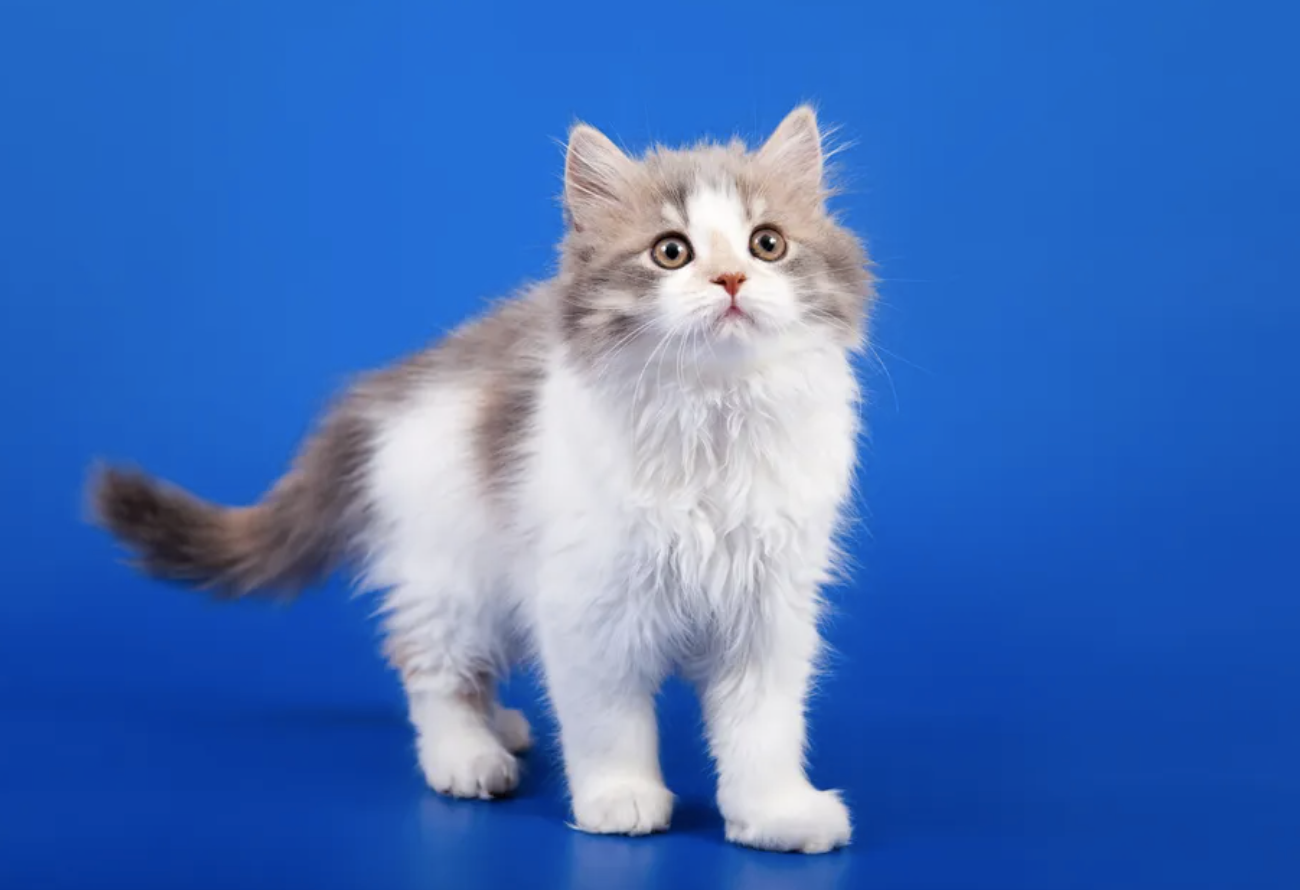

→ cat.png (유사도: 28.082)


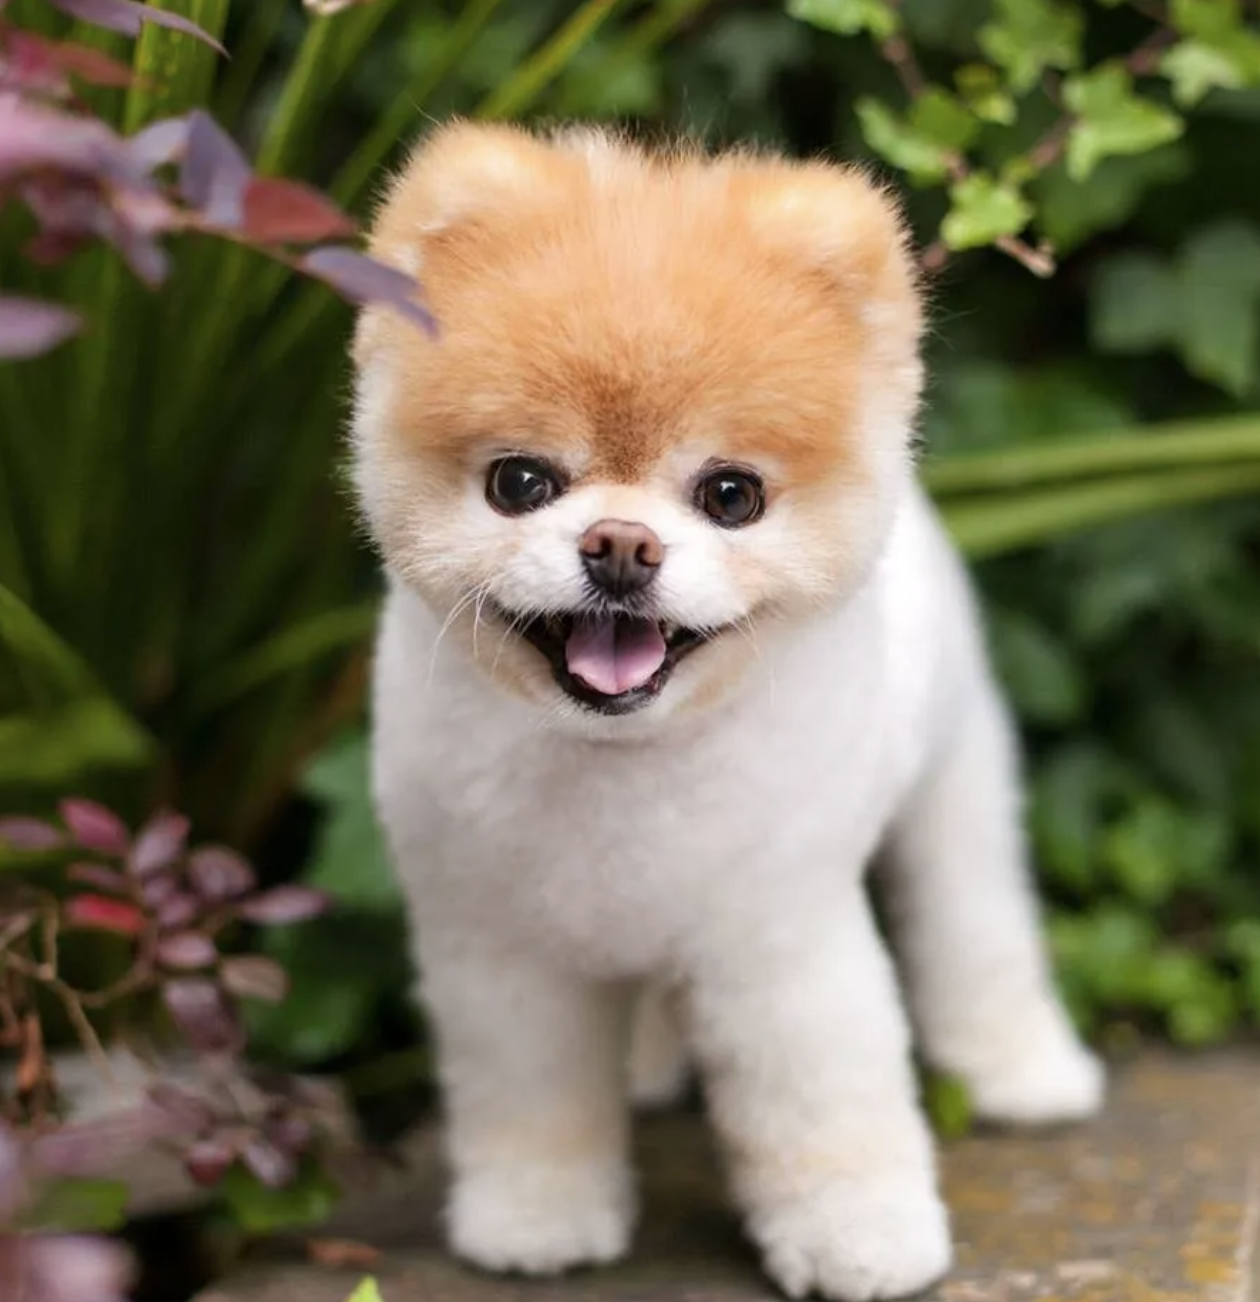

→ dog.png (유사도: 23.189)


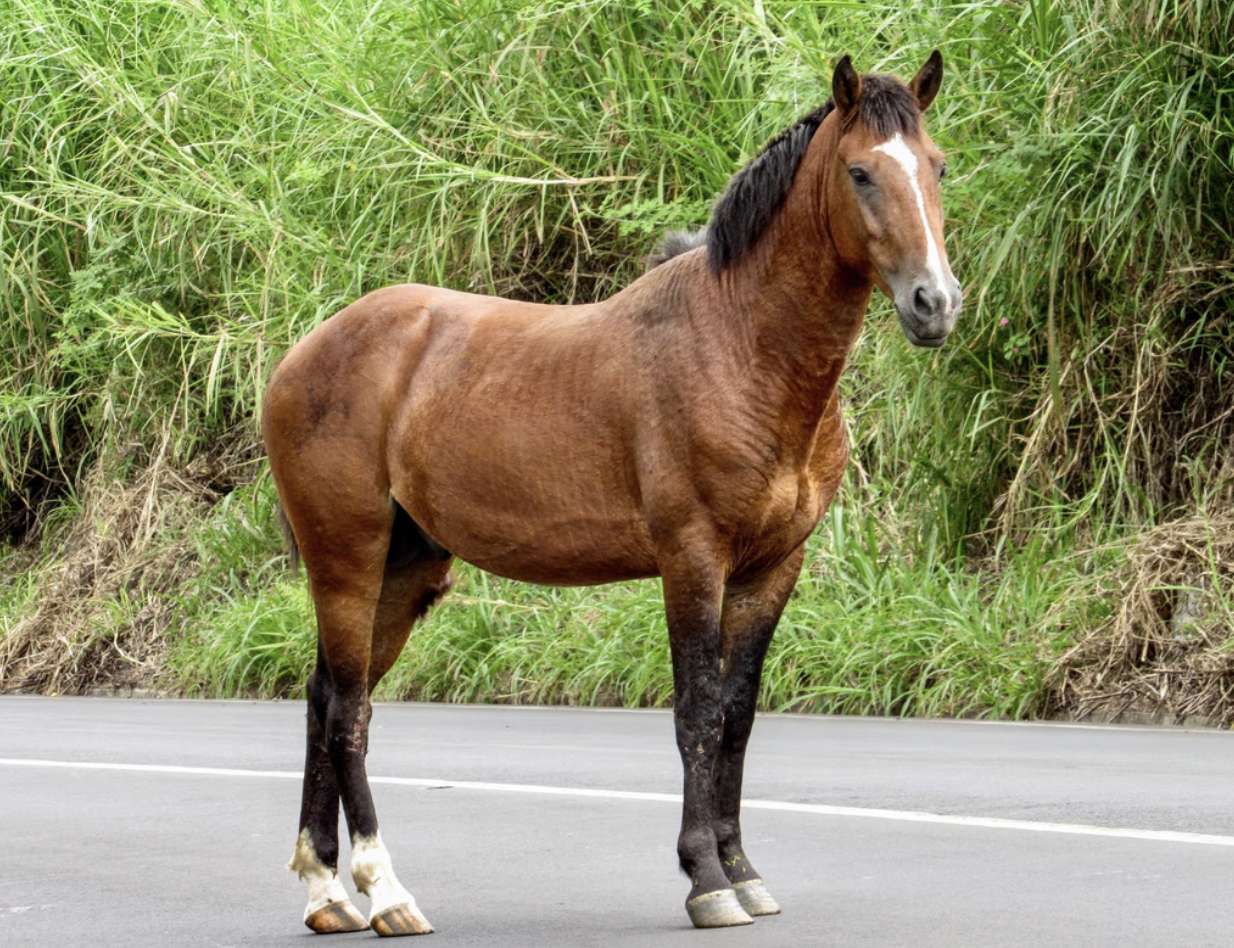

→ horse.png (유사도: 20.374)


In [8]:
import clip
import torch
from PIL import Image
import os
from IPython.display import display

# 1. 모델 로딩 및 장치 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 2. 이미지 폴더 설정
image_dir = "./images"
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png") or f.endswith(".jpg")]

# 3. 이미지 임베딩 미리 계산
image_tensors = [preprocess(Image.open(p)).unsqueeze(0).to(device) for p in image_paths]
image_input = torch.cat(image_tensors)
with torch.no_grad():
    image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)

# 4. 텍스트 입력 및 유사도 계산
query = "a photo of a cat"  # 사용자 입력
text_token = clip.tokenize([query]).to(device)

with torch.no_grad():
    text_feature = model.encode_text(text_token)
    text_feature /= text_feature.norm(dim=-1, keepdim=True)

similarities = (100.0 * text_feature @ image_features.T).squeeze()

# 5. Top-3 이미지 검색 결과 출력
top_k = similarities.topk(3).indices
print(f"\n입력 문장: \"{query}\"\n")
print("검색된 이미지:")
for i in top_k:
    display(Image.open(image_paths[i]))
    print(f"→ {os.path.basename(image_paths[i])} (유사도: {similarities[i].item():.3f})")


코드 3-5

In [9]:
!pip install transformers torchvision accelerate

In [10]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

# 1. 모델 및 프로세서 로딩
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 2. 이미지 불러오기 (파일 경로 수정 필요)
image = Image.open("/content/cat.png").convert("RGB")

# 3. 입력 전처리 및 캡션 생성
inputs = processor(images=image, return_tensors="pt").to(device)
out = model.generate(**inputs)

# 4. 출력 해석
caption = processor.decode(out[0], skip_special_tokens=True)
print("📸 이미지 설명:", caption)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

📸 이미지 설명: a small kitten on a blue background


코드 3-6

In [11]:
import clip
import torch
from PIL import Image
import os

# 1. 모델 로딩
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 2. 입력 이미지 불러오기
image = preprocess(Image.open("/content/dog.png")).unsqueeze(0).to(device)

# 3. 태그 후보 정의 (콘텐츠 주제)
tags = ["beach", "dog", "sunset", "food", "sports", "city skyline", "interior design"]
tag_tokens = clip.tokenize(tags).to(device)

# 4. 이미지 및 태그 임베딩 추출
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(tag_tokens)

# 5. 정규화 및 유사도 계산
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).squeeze()

# 6. 태깅 결과 출력 (Top-3)
top_k = similarity.topk(3).indices
print("🏷️ 추천 태그:")
for i in top_k:
    print(f"• {tags[i]} (유사도: {similarity[i]:.2f})")


🏷️ 추천 태그:
• dog (유사도: 27.33)
• food (유사도: 22.37)
• sports (유사도: 22.16)


In [12]:
# 1. 콘텐츠 이미지 폴더 설정
content_dir = "./images"
content_paths = [os.path.join(content_dir, f) for f in os.listdir(content_dir) if f.endswith(".jpg") or f.endswith(".png")]

# 2. 이미지 임베딩 벡터 계산
content_images = [preprocess(Image.open(p)).unsqueeze(0).to(device) for p in content_paths]
content_input = torch.cat(content_images)

with torch.no_grad():
    image_db_features = model.encode_image(content_input)
    image_db_features /= image_db_features.norm(dim=-1, keepdim=True)


In [13]:
# 기존 콘텐츠 이미지 임베딩 목록
# image_db_features: shape (N, 512)
# image_features: 입력 이미지 벡터 (1, 512)

# 유사도 계산
content_sim = (image_features @ image_db_features.T).squeeze()
recommend_indices = content_sim.topk(3).indices

print("유사 콘텐츠 추천:")
for i in recommend_indices:
    print(f"- 콘텐츠: {content_paths[i]} (유사도: {content_sim[i]:.2f})")


유사 콘텐츠 추천:
- 콘텐츠: ./images/dog.png (유사도: 1.00)
- 콘텐츠: ./images/cat.png (유사도: 0.79)
- 콘텐츠: ./images/horse.png (유사도: 0.66)


코드 3-7

In [14]:
!pip install ultralytics opencv-python torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00


In [15]:
import cv2
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
video_path = "/content/FA-50.mp4"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

frame_index = 0
highlight_frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(source=frame, conf=0.5, verbose=False)
    classes = [model.names[int(c)] for c in results[0].boxes.cls]

    if "person" in classes:  # 특정 객체 존재 여부 확인
        highlight_frames.append(frame_index)

    frame_index += 1

cap.release()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [16]:
highlight_frames

[4111,
 4113,
 4114,
 4115,
 4116,
 4117,
 4118,
 4119,
 4120,
 4121,
 4122,
 4123,
 4124,
 4125,
 4126,
 4127,
 4128,
 4129,
 4130,
 4131,
 4132,
 4133,
 4134,
 4135,
 4136,
 4137,
 4138,
 4139,
 4140,
 4141,
 4142,
 4143,
 4144,
 4145,
 4146,
 4147,
 4148,
 4149,
 4150,
 4151,
 4152,
 4153,
 4154,
 4155,
 4156,
 4157,
 4158,
 4159,
 4160,
 4161,
 4162,
 4163,
 4164,
 4165,
 4166,
 4167,
 4168,
 4169,
 4170,
 4171,
 4172,
 4173,
 4174,
 4175,
 4176,
 4177,
 4178,
 4179,
 4180,
 4181,
 4182,
 4183,
 4184,
 4185,
 4186,
 4187,
 4188,
 4189,
 4190,
 4191,
 4192,
 4193,
 4194,
 4195,
 4196,
 4197,
 4198,
 4199,
 4200,
 4201,
 4202,
 4203,
 4204,
 4205,
 4206,
 4207,
 4208,
 4209,
 4210,
 4211,
 4212,
 4213,
 4214,
 4215,
 4216,
 4217,
 4218,
 4219,
 4220,
 4221,
 4222,
 4223,
 4224,
 4225,
 4226,
 4227,
 4228,
 4229,
 4230,
 4231,
 4232,
 4233,
 4234,
 4235,
 4236,
 4237,
 4238,
 4239,
 4240,
 4241,
 4242,
 4243,
 4244,
 4245,
 4246,
 4247,
 4248,
 4249,
 4250,
 4251,
 4252,
 4253,
 4254,